In [1]:
from qiskit import *
from qiskit import QuantumCircuit
from qiskit.opflow import X, Y, Z, I
from qiskit.opflow.state_fns import StateFn
from qiskit.opflow import CircuitOp
from qiskit.opflow.expectations import PauliExpectation
from qiskit.opflow.converters import CircuitSampler
from qiskit.opflow import CircuitStateFn
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit import Parameter
from qiskit.utils import QuantumInstance
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def mixer(beta,num_qubit):
    codeword = QuantumRegister(num_qubit,'codeword')
    
    recieved = QuantumRegister(num_qubit,'recieved')
    circ = QuantumCircuit(codeword,recieved)
    
    circ.h(0)
    circ.h(1)
    circ.h(2)
    circ.cx(0,1)
    circ.cx(1,2)
    circ.rz(-2*beta,2)
    circ.cx(1,2)
    circ.cx(0,1)
    circ.h(0)
    circ.h(1)
    circ.h(2)
    
    circ.barrier()
    
    circ.h(0)
    circ.h(4)
    circ.h(5)
    circ.cx(0,4)
    circ.cx(4,5)
    circ.rz(-2*beta,5)
    circ.cx(4,5)
    circ.cx(0,4)
    circ.h(0)
    circ.h(4)
    circ.h(5)
    
    circ.barrier()
    
    circ.h(2)
    circ.h(3)
    circ.h(4)
    circ.cx(2,3)
    circ.cx(3,4)
    circ.rz(-2*beta,4)
    circ.cx(3,4)
    circ.cx(2,3)
    circ.h(2)
    circ.h(3)
    circ.h(4)
    
    circ.barrier()

    circ.h(1)
    circ.h(3)
    circ.h(5)
    circ.cx(1,3)
    circ.cx(3,5)
    circ.rz(-2*beta,5)
    circ.cx(3,5)
    circ.cx(1,3)
    circ.h(1)
    circ.h(3)
    circ.h(5)
    
    circ.barrier()
    return circ

In [3]:
def cost_unitary(gamma,num_qubit):
    codeword = QuantumRegister(num_qubit,'codeword')
    recieved = QuantumRegister(num_qubit,'recieved')
    circ = QuantumCircuit(codeword,recieved)
    for i in range(num_qubit):
        circ.cx(codeword[i],recieved[i])
        circ.rz((-gamma),recieved[i])
        circ.cx(codeword[i],recieved[i])
        circ.barrier()
    
    return circ

In [4]:
# # beta and gamma is a list of length p

# # Try for fixed parameter:

# def create_qaoa_circ(beta,gamma,num_qubit,p,r):  
        
#     codeword = QuantumRegister(num_qubit,'codeword')
#     recieved = QuantumRegister(num_qubit,'recieved')
#     #cbit = ClassicalRegister(num_qubit)
#     circ = QuantumCircuit(codeword,recieved)#,cbit)

#     # if the codeword recieved is r = |0010>, in qiskit the 1 is in the 1st position of recieved register.
    
#     for i in range(len(r)):
#         if r[i] == '1':
#             circ.x(recieved[i])
    
#     circ.h(range(3))
    
#     circ.cx(0,4)
#     circ.cx(0,5)
    
#     circ.cx(1,3)
#     circ.cx(1,5)
    
#     circ.cx(2,3)
#     circ.cx(2,4)
    
#     circ.barrier()
    
#     for i in range(p):
        
#         # The time evolution unitary of cost hamiltonian:
        
#         circ.append(mixer(beta[i],num_qubit),range(2*num_qubit))
#         circ.append(cost_unitary(gamma[i],num_qubit),range(2*num_qubit))
        
    
#     return circ

In [5]:
# Try for uniform parameter:

def create_qaoa_circ(theta,num_qubit,p,r):
    
    beta = theta[0]
    gamma = theta[1]

    codeword = QuantumRegister(num_qubit,'codeword')
    #ancila = QuantumRegister(num_qubit,'ancila')
    recieved = QuantumRegister(num_qubit,'recieved')
    
    circ = QuantumCircuit(codeword,recieved)

    # if the codeword recieved is r = |0010>, in qiskit the 1 is in the 1st position of recieved register.
    
    for i in range(len(r)):
        if r[i] == '1':
            circ.x(recieved[i])
    
    circ.h(range(3))
    
    circ.cx(0,4)
    circ.cx(0,5)
    
    circ.cx(1,3)
    circ.cx(1,5)
    
    circ.cx(2,3)
    circ.cx(2,4)
    
    circ.barrier()
    
    for i in range(p):

        
        # The time evolution unitary of cost hamiltonian:
        
        circ.append(mixer(beta,num_qubit),range(2*num_qubit))
        circ.append(cost_unitary(gamma,num_qubit),range(2*num_qubit))

    
    return circ



In [6]:
# gamma = 0.0111#Parameter("$\\gamma$") 

# beta = np.pi#Parameter("$\\beta$")

#### for p = 3. beta = [beta1,beta2,beta3] and gamma = [gamma1,gamma2,gamma3]


def expectation(theta_beta,theta_gamma):
#     beta = [10.718126298624355,17.033301639108966,theta_beta]
#     gamma = [112.2159171046257,122.4372617692916,theta_gamma]
    
    psi = create_qaoa_circ([theta_beta,theta_gamma],num_qubit = 6,p = 3,r = '111011')
    
#     psi = create_qaoa_circ([theta_beta,theta_gamma],num_qubit = 6,p = 3,r = '111011')
    

    psi = CircuitStateFn(psi)

    H = (0.5 * I^I^I^I^I^I^I^I^I^I^I^I) + (0.5 * I^I^I^I^I^I^I^I^I^I^I^I) \
        +(0.5 * I^I^I^I^I^I^I^I^I^I^I^I) + (0.5 * I^I^I^I^I^I^I^I^I^I^I^I) \
        + (0.5 * I^I^I^I^I^I^I^I^I^I^I^I) + (0.5 * I^I^I^I^I^I^I^I^I^I^I^I) \
        - (0.5 * Z^I^I^I^I^I^Z^I^I^I^I^I) - (0.5 * I^Z^I^I^I^I^I^Z^I^I^I^I) \
        - (0.5 * I^I^Z^I^I^I^I^I^Z^I^I^I) - (0.5 * I^I^I^Z^I^I^I^I^I^Z^I^I) \
        - (0.5 * I^I^I^I^Z^I^I^I^I^I^Z^I) - (0.5 * I^I^I^I^I^Z^I^I^I^I^I^Z)

    measurable_expression = StateFn(H, is_measurement = True).compose(psi)
    
    expect = PauliExpectation().convert(measurable_expression)

    simulator = QasmSimulator()
    
    q_instance = QuantumInstance(simulator, shots = 2000)
    
    sampler = CircuitSampler(q_instance).convert(expect)

    r = sampler.eval().real
    
    return r

In [7]:
# These values are nothing..

# beta1 = np.arange(0.0,np.pi,0.05)
# beta2 = np.arange(0.0,np.pi,0.05)
# beta3 = np.arange(0.0,np.pi,0.05)

# gamma1 = np.arange(0.0,2*np.pi,0.05)
# gamma2 = np.arange(0.0,2*np.pi,0.05)
# gamma3 = np.arange(0.0,2*np.pi,0.05)

theta_beta = np.arange(0.0,np.pi,0.02)
theta_gamma = np.arange(0.0,2*np.pi,0.02)


x, y = np.meshgrid(theta_beta,theta_gamma)
f = np.vectorize(expectation)

z = f(x,y)



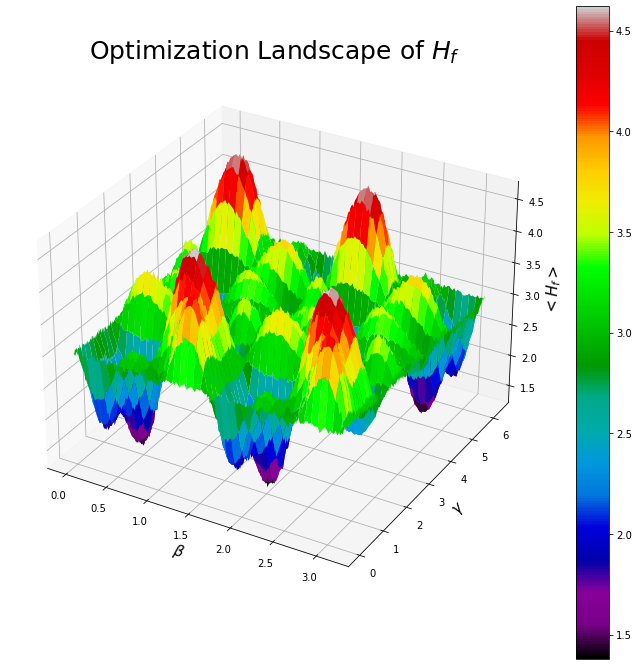

In [8]:
fig = plt.figure(figsize = (12,12))
ax = plt.axes(projection='3d')


# Creating color map
my_cmap = plt.get_cmap('nipy_spectral')          # 'nipy_spectral' 'hsv' 'turbo' 'hot''ocean' 'rainbow' twilight

surf = ax.plot_surface(x,y,z,cmap = my_cmap,
                       edgecolor ='none',shade = True)






#fig.colorbar(surf, ax, shrink=0.5, aspect=5)

# Set axes label
ax.set_xlabel("$\\beta$",fontsize = 15)
ax.set_ylabel("$\\gamma$",fontsize = 15)
ax.set_zlabel('$<H_f>$',fontsize = 15)
ax.set_title('Optimization Landscape of $H_f$',fontsize = 25)
fig.colorbar(surf)

plt.savefig('land633_300_upo.png',dpi = 300)


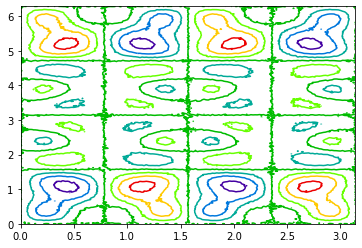

In [9]:
fig1 = plt.figure()
ax1 = plt.axes()
ax1.contour(x,y,z,cmap = 'nipy_spectral')
plt.show()